<a href="https://colab.research.google.com/github/mchchoi/permutation/blob/main/Blume-Capel/Blume-Capel_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

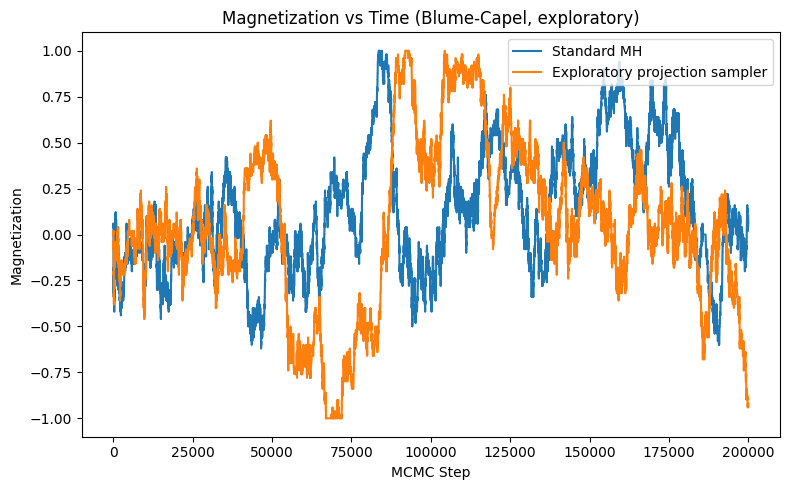

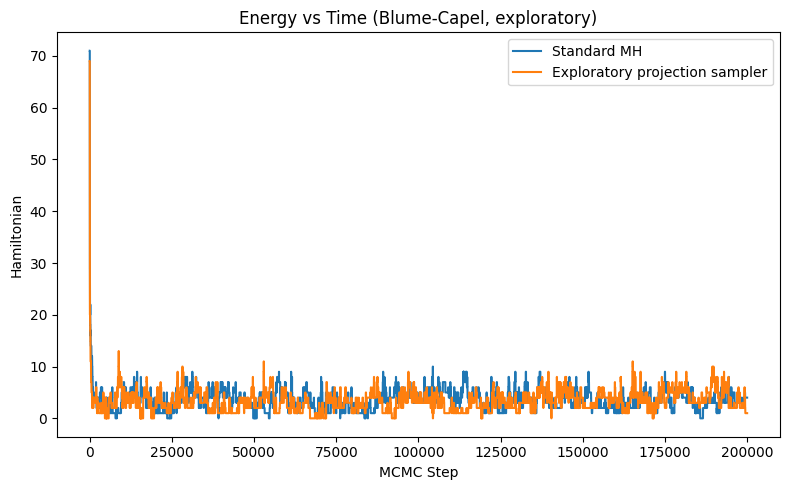

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
np.random.seed(1500)
d = 50                # Number of spins
n_explore = 200000    # Exploration steps for building Q
n_sample = 200000     # Sampling steps using projection sampler
beta_high = 0.1       # High temperature for exploration
beta_target = 3       # Target inverse temperature
tolerance = 1e-6      # Energy comparison tolerance

# --- Blume-Capel Hamiltonian on a line ---
def hamiltonian(x):
    """H(x) = sum_{i=1}^{d-1} (sigma_i - sigma_{i+1})^2"""
    return np.sum((x[:-1] - x[1:])**2)

# --- Spin-flip Proposal for Blume-Capel ---
def metropolis_step(x, beta):
    x_new = x.copy()
    i = np.random.randint(d)
    current_val = x[i]
    # Propose a different spin value from {-1, 0, 1}
    proposal_vals = [-1, 0, 1]
    proposal_vals.remove(current_val)
    x_new[i] = np.random.choice(proposal_vals)
    delta_H = hamiltonian(x_new) - hamiltonian(x)
    if np.random.rand() < np.exp(-beta * delta_H):
        return x_new
    else:
        return x

# --- Exploration Phase using High-Temp MH ---
x = np.random.choice([-1, 0, 1], size=d)
original = x.copy()
trajectory = []
energies = []

for _ in range(n_explore):
    x = metropolis_step(x, beta_high)
    trajectory.append(x.copy())
    energies.append(hamiltonian(x))

# --- Build Q from Exploration Trajectory ---
Q_dict = {}
for i in range(n_explore):
    x_i = trajectory[i]
    x_i_str = x_i.tobytes()
    if x_i_str in Q_dict:
        continue
    H_i = energies[i]
    for j in range(i + 1, n_explore):
        x_j = trajectory[j]
        x_j_str = x_j.tobytes()
        if x_j_str in Q_dict:
            continue
        if np.isclose(H_i, energies[j], atol=tolerance):
            Q_dict[x_i_str] = x_j.copy()
            Q_dict[x_j_str] = x_i.copy()
            break

# --- Define Q Permutation ---
def Q_permutation(x):
    x_str = x.tobytes()
    return Q_dict.get(x_str, x.copy())

# --- Projection Metropolis Step using Fixed Q ---
def metropolis_step_projection(x, beta):
    y1 = metropolis_step(x, beta)
    y2 = Q_permutation(metropolis_step(Q_permutation(x), beta))
    return y1 if np.random.rand() < 0.5 else y2

# --- Magnetization ---
def magnetization(x):
    return np.mean(x)

# --- Run Sampling Phase ---
x_proj = original.copy()
x_std = original.copy()

mag_proj = np.zeros(n_sample)
mag_std = np.zeros(n_sample)
energy_proj = np.zeros(n_sample)
energy_std = np.zeros(n_sample)

for t in range(n_sample):
    x_proj = metropolis_step_projection(x_proj, beta_target)
    x_std = metropolis_step(x_std, beta_target)

    mag_proj[t] = magnetization(x_proj)
    mag_std[t] = magnetization(x_std)
    energy_proj[t] = hamiltonian(x_proj)
    energy_std[t] = hamiltonian(x_std)

# --- Plot Results ---
plt.figure(figsize=(8, 5))
plt.plot(mag_std, label='Standard MH')
plt.plot(mag_proj, label='Exploratory projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Magnetization')
plt.title('Magnetization vs Time (Blume-Capel, exploratory)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_magnetization_exploratory.png')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(energy_std, label='Standard MH')
plt.plot(energy_proj, label='Exploratory projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Hamiltonian')
plt.title('Energy vs Time (Blume-Capel, exploratory)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_energy_exploratory.png')
plt.show()


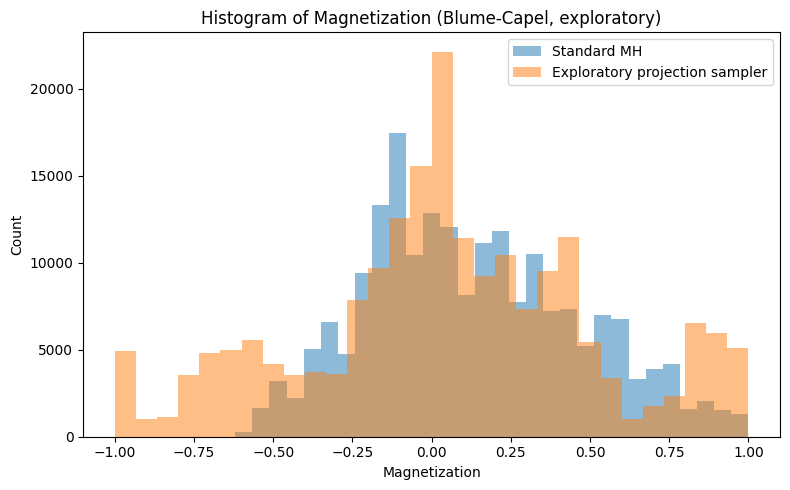

In [2]:
plt.figure(figsize=(8, 5))
plt.hist(mag_std[-200000:], bins=30, alpha=0.5, label='Standard MH', density=False)
plt.hist(mag_proj[-200000:], bins=30, alpha=0.5, label='Exploratory projection sampler', density=False)
plt.xlabel('Magnetization')
plt.ylabel('Count')
plt.title('Histogram of Magnetization (Blume-Capel, exploratory)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_histogram_exploratory.png')
plt.show()

In [3]:
def average_jump_distance(mag_series):
    """
    Computes the average one-step jump distance of magnetization.

    Parameters:
        mag_series (np.ndarray): Array of magnetization values over time.

    Returns:
        float: Average jump distance.
    """
    diffs = np.abs(np.diff(mag_series))
    return np.mean(diffs)

jump_std = average_jump_distance(mag_std)
jump_mod = average_jump_distance(mag_proj)

print(f"Average jump distance (Standard MH): {jump_std:.5f}")
print(f"Average jump distance (Projection MH): {jump_mod:.5f}")

Average jump distance (Standard MH): 0.00144
Average jump distance (Projection MH): 0.00136


In [4]:
import numpy as np
from scipy.stats import norm

def compute_summary_stats(samples, name=""):
    samples = np.asarray(samples)
    mean = np.mean(samples)
    var = np.var(samples, ddof=1)  # Sample variance
    n = len(samples)

    # Estimate ESS
    def compute_ess(trace):
        n = len(trace)
        trace = trace - np.mean(trace)
        acov = np.correlate(trace, trace, mode='full')[n-1:] / np.arange(n, 0, -1)
        acov /= acov[0]
        cutoff = np.where(acov < 0)[0]
        cutoff = cutoff[0] if len(cutoff) > 0 else n
        tau = 1 + 2 * np.sum(acov[1:cutoff])
        return n / tau

    ess = compute_ess(samples)

    # Standard error and 95% CI
    std_err = np.sqrt(var / ess)
    z = norm.ppf(0.975)  # For 95% CI
    ci_low, ci_high = mean - z * std_err, mean + z * std_err

    print(f"--- {name} ---")
    print(f"Sample mean     : {mean:.6f}")
    print(f"Sample variance : {var:.6f}")
    print(f"ESS             : {ess:.2f}")
    print(f"95% CI          : [{ci_low:.6f}, {ci_high:.6f}]\n")

# Run this after MCMC loop
compute_summary_stats(mag_std, name="Standard MH")
compute_summary_stats(mag_proj, name="Projection sampler")

--- Standard MH ---
Sample mean     : 0.131116
Sample variance : 0.113260
ESS             : 15.58
95% CI          : [-0.035979, 0.298211]

--- Projection sampler ---
Sample mean     : 0.048620
Sample variance : 0.209151
ESS             : 9.73
95% CI          : [-0.238669, 0.335909]



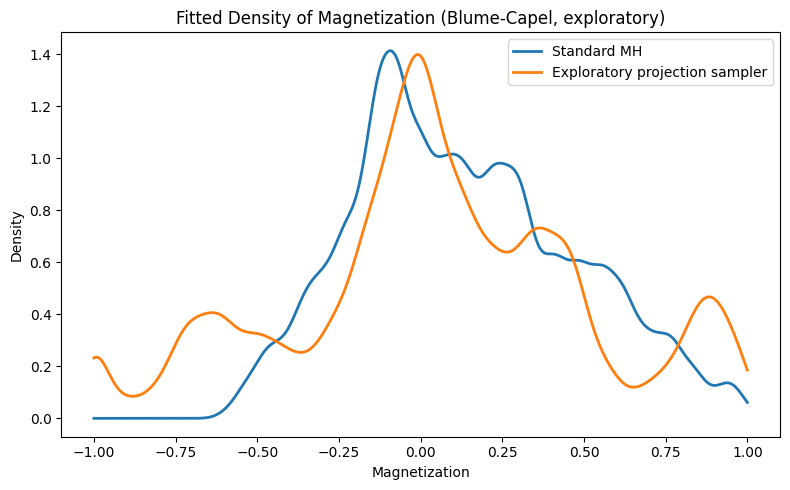

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# Compute KDEs
kde_std = gaussian_kde(mag_std)
kde_proj = gaussian_kde(mag_proj)

x_vals = np.linspace(min(np.min(mag_std), np.min(mag_proj)),
                     max(np.max(mag_std), np.max(mag_proj)), 500)

# Plot histograms with density=True and overlay KDE curves
plt.figure(figsize=(8, 5))
#plt.hist(mag_std, bins=30, alpha=0.4, label='Standard MH', density=True)
#plt.hist(mag_proj, bins=30, alpha=0.4, label='Exploratory projection sampler', density=True)

plt.plot(x_vals, kde_std(x_vals), lw=2, label='Standard MH')
plt.plot(x_vals, kde_proj(x_vals), lw=2, label='Exploratory projection sampler')

plt.xlabel('Magnetization')
plt.ylabel('Density')
plt.title('Fitted Density of Magnetization (Blume-Capel, exploratory)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_histogram_density_exploratory.png')
plt.show()